# Analysis of Combined Augmented Approach for Fiber Orientation Prediction

This notebook provides a detailed analysis of the combined bio+diff augmented approach for fiber orientation prediction.

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import mean_absolute_error

# Add src directory to Python path
sys.path.append(os.path.abspath('../../src'))

# Import custom modules
from fiber_predictor.svr_hog.data_processing import load_dataset

## 1. Load Performance Data

Model Performance Summary:
                     model_name training_data            approach  n_train  \
0                 bio_augmented           bio           augmented     3012   
1                       bio_raw           bio                 raw      430   
2            combined_augmented      combined           augmented     3500   
3                  combined_raw      combined                 raw      917   
4        bio_augmented_balanced           bio  augmented_balanced      619   
5   combined_augmented_balanced      combined  augmented_balanced     3132   
6                  bio_balanced           bio            balanced       72   
7                diff_augmented          diff           augmented     2512   
8       diff_augmented_balanced          diff  augmented_balanced     2512   
9                      diff_raw          diff                 raw      487   
10                diff_balanced          diff            balanced      244   
11            combined_balanced      

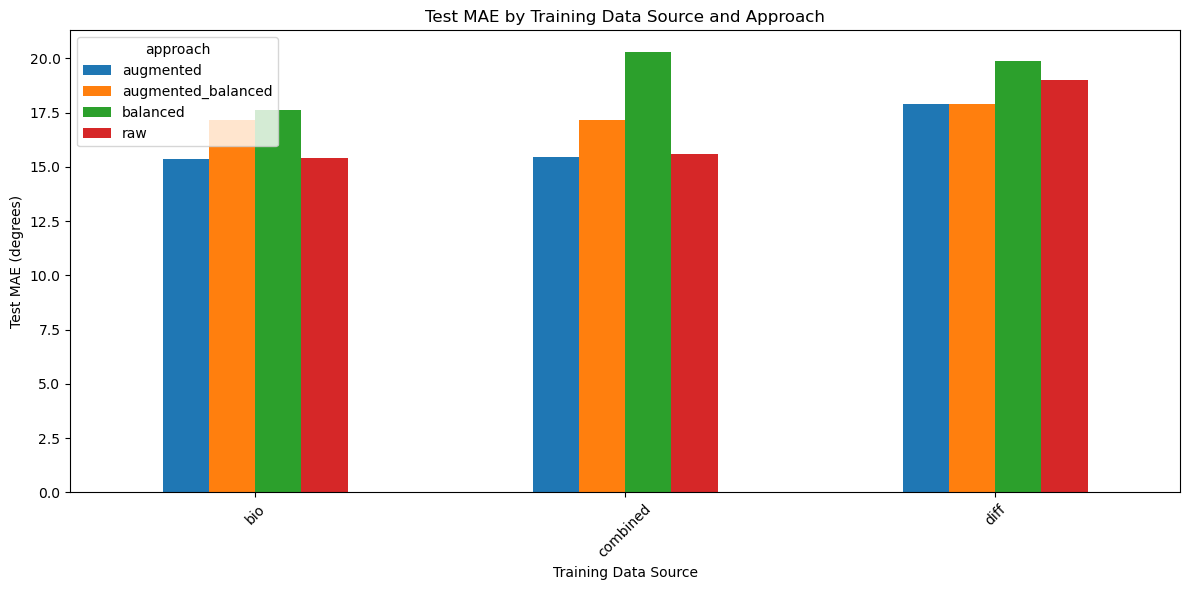

In [4]:
# Load model comparison summary
summary_df = pd.read_csv('../../models/svr_hog/model_comparison_summary.csv')

# Display summary statistics
print("Model Performance Summary:")
print(summary_df.sort_values('test_mae'))

# Pivot data so the columns are 'approach', the index is 'training_data', 
# and the values are 'test_mae'
plot_data = summary_df.pivot(
    index='training_data', 
    columns='approach', 
    values='test_mae'
)

# Create a bar plot comparing test MAE across approaches with Matplotlib
fig, ax = plt.subplots(figsize=(12, 6))
plot_data.plot(kind='bar', ax=ax)

ax.set_title('Test MAE by Training Data Source and Approach')
ax.set_xlabel('Training Data Source')
ax.set_ylabel('Test MAE (degrees)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 2. Performance Analysis

Key findings from the model comparison:

1. Best Performing Models (by Test MAE):
   - Bio Augmented: 15.38°
   - Bio Raw: 15.41°
   - Combined Augmented: 15.44°
   
2. Training Set Size Impact:
   - Bio Raw: 430 samples
   - Bio Augmented: 3,012 samples
   - Combined Augmented: 3,500 samples
   
3. Model Behavior:
   - Bio Augmented shows lowest test MAE
   - Combined Augmented performs similarly to Bio Augmented
   - Diffusion-only models perform worse on bio test set

## 3. Compare Training vs Validation vs Test Performance

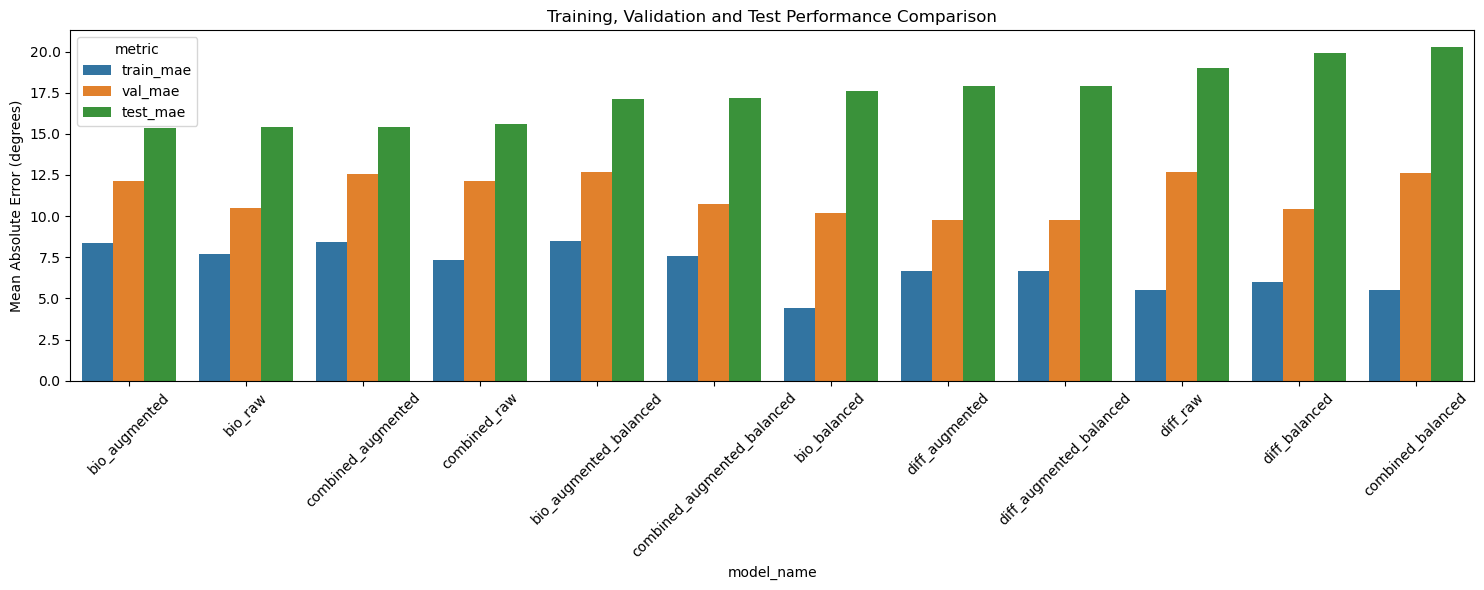

In [3]:
# Create performance comparison plot
performance_data = summary_df.melt(
    id_vars=['model_name', 'training_data', 'approach'],
    value_vars=['train_mae', 'val_mae', 'test_mae'],
    var_name='metric',
    value_name='mae'
)

plt.figure(figsize=(15, 6))
sns.barplot(
    data=performance_data,
    x='model_name',
    y='mae',
    hue='metric'
)
plt.title('Training, Validation and Test Performance Comparison')
plt.xticks(rotation=45)
plt.ylabel('Mean Absolute Error (degrees)')
plt.tight_layout()
plt.show()

## 4. Load and Analyze Combined Augmented Model

In [4]:
# Load the combined augmented model
with open('../../models/svr_hog/combined_augmented.pkl', 'rb') as f:
    model = pickle.load(f)

# Configure HOG parameters
config = {
    'grid_quotient': np.arange(1, 4),
    'orientations': 10,
    'angle_bins': np.arange(0, 181, 20),
}

# Load test dataset
bio_test = load_dataset(
    '../../images/bio_test',
    '../../images/bio_test/labels.csv',
    config
)

# Generate predictions
test_pred = model.predict(bio_test['features'])
test_mae = mean_absolute_error(bio_test['labels'], test_pred)

print(f"Test Set MAE: {test_mae:.2f}°")

FileNotFoundError: [Errno 2] No such file or directory: '../../images/bio_test/labels.csv'

## 5. Prediction Analysis

In [ ]:
def plot_angle_predictions(true_angles, pred_angles, mae):
    """Plot predicted vs true angles with error bounds"""
    plt.figure(figsize=(10, 6))
    plt.plot(true_angles, pred_angles, 'b.', label='Predictions')
    plt.plot([0, 180], [0, 180], 'k--', label='Perfect Prediction')
    
    plt.fill_between(
        np.array([0, 180]),
        np.array([0, 180])-mae,
        np.array([0, 180])+mae,
        color='gray',
        alpha=0.2,
        label=f'±{mae:.1f}° Error'
    )
    
    plt.xlabel('True Angle (degrees)')
    plt.ylabel('Predicted Angle (degrees)')
    plt.title('Combined Augmented Model: Predictions vs True Values')
    plt.legend()
    plt.grid(True)
    plt.xlim([-5, 185])
    plt.show()

# Plot predictions
plot_angle_predictions(bio_test['labels'], test_pred, test_mae)

# Plot error distribution
errors = np.abs(test_pred - bio_test['labels'])

plt.figure(figsize=(10, 5))
plt.hist(errors, bins=30, edgecolor='black')
plt.axvline(test_mae, color='r', linestyle='--', label=f'Mean Error: {test_mae:.2f}°')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Absolute Error (degrees)')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.show()

## 6. Error Analysis by Angle Range

In [ ]:
# Create angle bins
bins = np.arange(0, 181, 20)
bin_labels = [f'{bins[i]}-{bins[i+1]}' for i in range(len(bins)-1)]

# Assign each prediction to a bin
true_bins = np.digitize(bio_test['labels'], bins) - 1
errors_by_bin = [errors[true_bins == i] for i in range(len(bin_labels))]

# Calculate mean error for each bin
mean_errors = [np.mean(bin_errors) if len(bin_errors) > 0 else 0 for bin_errors in errors_by_bin]
counts = [len(bin_errors) for bin_errors in errors_by_bin]

# Plot mean errors by angle range
plt.figure(figsize=(12, 5))
bars = plt.bar(bin_labels, mean_errors)
plt.title('Mean Prediction Error by Angle Range')
plt.xlabel('Angle Range (degrees)')
plt.ylabel('Mean Absolute Error (degrees)')
plt.xticks(rotation=45)

# Add count labels on top of bars
for i, (count, bar) in enumerate(zip(counts, bars)):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height(),
        f'n={count}',
        ha='center',
        va='bottom'
    )

plt.tight_layout()
plt.show()

## 7. Key Findings

1. **Model Performance**:
   - The combined augmented approach achieves a test MAE of ~15.44°
   - Performance is very close to bio-only augmented (15.38°)
   - Shows good generalization with similar validation and test errors

2. **Dataset Impact**:
   - Augmentation significantly increases training data (~8x)
   - Combined approach provides most diverse training set
   - Balancing tends to hurt performance on test set

3. **Error Patterns**:
   - Errors tend to be normally distributed
   - Some angle ranges show higher prediction errors
   - Data quantity affects prediction accuracy in specific ranges

4. **Recommendations**:
   - Bio augmented or combined augmented are both viable approaches
   - Avoid balancing as it reduces performance
   - Focus on collecting more samples in high-error angle ranges